In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/online shoppers intention')

In [0]:
pip install feature_engine

In [0]:
pip install scikit-optimize

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce
from sklearn.metrics import roc_curve
from sklearn.metrics  import confusion_matrix as cm
from sklearn.metrics import classification_report as cr
from sklearn.utils import resample
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from xgboost import XGBClassifier as XGB

In [0]:
dataset = pd.read_csv('online_shoppers_intention.csv')

In [0]:
dataset.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [0]:
dataset.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [0]:
for var in dataset.columns:
    print(var, dataset[var].unique()[0:30], '\n')

Administrative [ 0  1  2  4 12  3 10  6  5  9  8 16 13 11  7 18 14 17 19 15 24 22 21 20
 23 27 26] 

Administrative_Duration [   0.           53.           64.6           6.           18.
    9.           56.           16.          279.4166667    87.83333333
   44.         1005.666667     36.           18.33333333   61.
   31.           58.5         326.25         22.          462.
   20.          111.5         103.625        19.           58.
    9.5          41.3          87.          293.7782051    47.        ] 

Informational [ 0  1  2  4 16  5  3 14  6 12  7  9 10  8 11 24 13] 

Informational_Duration [   0.          120.           16.           94.           93.
   75.           19.           22.         1210.397619    153.
   48.5          51.            3.          144.          125.
  127.          261.          306.3333333    84.          740.
  303.25         21.5        1220.          235.          100.
   64.           47.          205.           70.           14.33333333]

In [0]:
discrete_cols = [var for var in dataset.columns if dataset[var].dtype!='O' and var!='Revenue' and dataset[var].nunique()<25]
continuous_cols = [var for var in dataset.columns if dataset[var].dtype!='O' and var!='Revenue' and var not in discrete_cols]

categorical_cols = [var for var in dataset.columns if dataset[var].dtype=='O']

print('There are {} discrete variables'.format(len(discrete_cols)))
print('There are {} continuous variables'.format(len(continuous_cols)))
print('There are {} categorical variables'.format(len(categorical_cols)))

There are 7 discrete variables
There are 8 continuous variables
There are 2 categorical variables


In [0]:
discrete_cols

['Informational',
 'SpecialDay',
 'OperatingSystems',
 'Browser',
 'Region',
 'TrafficType',
 'Weekend']

In [0]:
continuous_cols

['Administrative',
 'Administrative_Duration',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues']

In [0]:
categorical_cols

['Month', 'VisitorType']

In [0]:
continuous_cols

['Administrative',
 'Administrative_Duration',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues']

In [0]:
categorical_cols

['Month', 'VisitorType']

In [0]:
dataset.isnull().mean()

Administrative             0.0
Administrative_Duration    0.0
Informational              0.0
Informational_Duration     0.0
ProductRelated             0.0
ProductRelated_Duration    0.0
BounceRates                0.0
ExitRates                  0.0
PageValues                 0.0
SpecialDay                 0.0
Month                      0.0
OperatingSystems           0.0
Browser                    0.0
Region                     0.0
TrafficType                0.0
VisitorType                0.0
Weekend                    0.0
Revenue                    0.0
dtype: float64

In [0]:
dataset[categorical_cols].nunique()

Month          10
VisitorType     3
dtype: int64

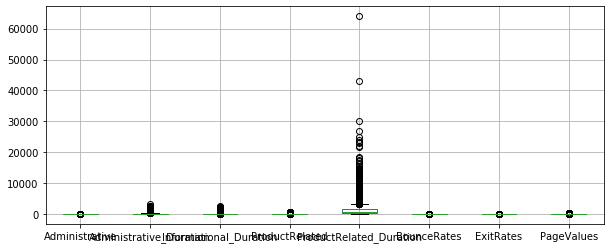

In [0]:
dataset[continuous_cols].boxplot(figsize=(10,4))

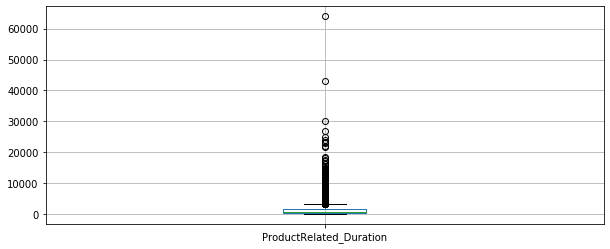

In [0]:
dataset[['ProductRelated_Duration']].boxplot(figsize=(10,4))

In [0]:
dataset['ProductRelated_Duration'].value_counts()

0.000000       755
17.000000       21
8.000000        17
11.000000       17
15.000000       16
              ... 
6560.007540      1
821.893333       1
2004.500000      1
266.500000       1
1919.550000      1
Name: ProductRelated_Duration, Length: 9551, dtype: int64

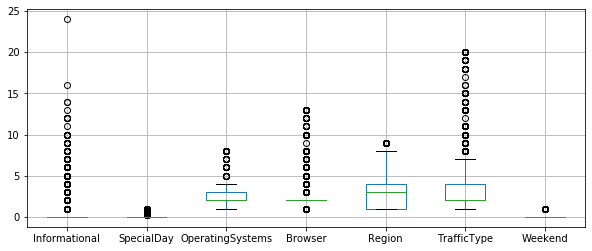

In [0]:
dataset[discrete_cols].boxplot(figsize=(10,4))

In [0]:
dataset['Informational'].value_counts()

0     9699
1     1041
2      728
3      380
4      222
5       99
6       78
7       36
9       15
8       14
10       7
12       5
14       2
11       1
13       1
24       1
16       1
Name: Informational, dtype: int64

In [0]:
dataset.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop('Revenue', axis=1),  
    dataset['Revenue'],  
    test_size=0.2,  
    stratify=dataset['Revenue'],
    random_state=0)  

X_train.shape, X_test.shape

((9864, 17), (2466, 17))

In [0]:
X_train.select_dtypes(exclude='O').isnull().mean()

Administrative             0.0
Administrative_Duration    0.0
Informational              0.0
Informational_Duration     0.0
ProductRelated             0.0
ProductRelated_Duration    0.0
BounceRates                0.0
ExitRates                  0.0
PageValues                 0.0
SpecialDay                 0.0
OperatingSystems           0.0
Browser                    0.0
Region                     0.0
TrafficType                0.0
Weekend                    0.0
dtype: float64

In [0]:
X_train.select_dtypes(include='O').isnull().mean()

Month          0.0
VisitorType    0.0
dtype: float64

In [0]:
for var in categorical_cols:
    print((X_train[var].value_counts() / len(X_train)).sort_values())
    print('-' * 50, '\n')

Feb     0.013889
June    0.023418
Aug     0.034874
Jul     0.035280
Sep     0.035888
Oct     0.044708
Dec     0.142437
Mar     0.156326
Nov     0.240775
May     0.272405
Name: Month, dtype: float64
-------------------------------------------------- 

Other                0.006691
New_Visitor          0.137875
Returning_Visitor    0.855434
Name: VisitorType, dtype: float64
-------------------------------------------------- 



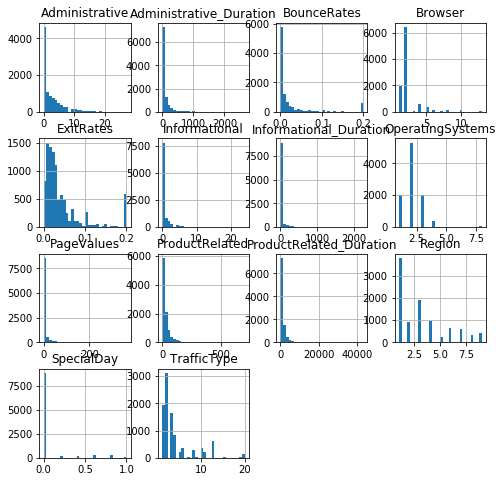

In [0]:
X_train.select_dtypes(exclude=['O', 'bool']).hist(bins=30, figsize=(8,8))
plt.show()

In [0]:
pipeline = Pipeline([

    ('categorical_encoder',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=['Month', 'VisitorType'])),

    # Gradient Boosted machin
    ('gbm', GradientBoostingClassifier(random_state=0))
])

In [0]:
print((y_train.value_counts() / len(y_train)).sort_values())

True     0.154704
False    0.845296
Name: Revenue, dtype: float64


In [0]:
pipeline.fit(X_train, y_train)

X_train_preds = pipeline.predict_proba(X_train)[:,1]
X_test_preds = pipeline.predict_proba(X_test)[:,1]

In [0]:
pipeline.predict_proba(X_train)[:,1]

array([0.12867279, 0.00936082, 0.55617473, ..., 0.325124  , 0.44049244,
       0.40510832])

In [0]:
X_train_preds

array([0.12867279, 0.00936082, 0.55617473, ..., 0.325124  , 0.44049244,
       0.40510832])

In [0]:
train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)
test_preds

array([False, False, False, ..., False, False, False])

In [0]:
print('Train set')
print('GBM roc-auc: {}'.format(roc_auc_score(y_train, X_train_preds)))

print('Test set')
print('GBM roc-auc: {}'.format(roc_auc_score(y_test, X_test_preds)))

Train set
GBM roc-auc: 0.9467834185857231
Test set
GBM roc-auc: 0.9329087990272432


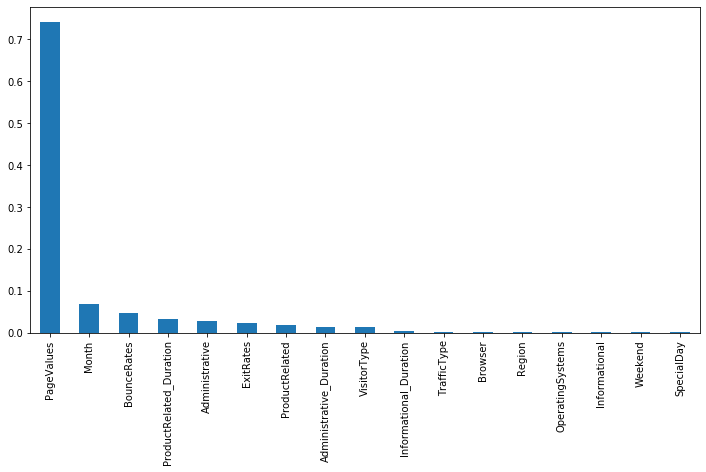

In [0]:
importance = pd.Series(pipeline.named_steps['gbm'].feature_importances_)
importance.index = dataset.drop('Revenue', axis=1).columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, X_test_preds)

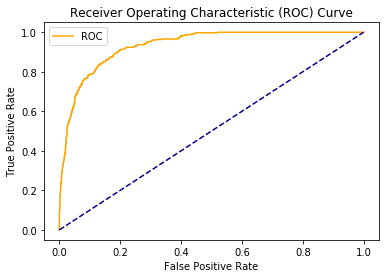

In [0]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
plot_roc_curve(fpr, tpr)

In [0]:
cm(y_test, test_preds)

array([[1998,   86],
       [ 155,  227]])

In [0]:
print(cr(y_test, test_preds))

              precision    recall  f1-score   support

       False       0.93      0.96      0.94      2084
        True       0.73      0.59      0.65       382

    accuracy                           0.90      2466
   macro avg       0.83      0.78      0.80      2466
weighted avg       0.90      0.90      0.90      2466



## new way

In [0]:
a = dataset[dataset['Revenue']==1].shape[0]
b = dataset[dataset['Revenue']==0].shape[0]
print(f'Dataset True-class percentage = {a/(a+b)}')

Dataset True-class percentage = 0.15474452554744525


In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop('Revenue', axis=1),  
    dataset['Revenue'],  
    test_size=0.2,  
    stratify=dataset['Revenue'],
    random_state=0)  

X_train.shape, X_test.shape

((9864, 17), (2466, 17))

In [0]:
a = y_train[y_train == 1].count()
b = y_train[y_train == 0].count()
print(f'Training-set True-class percentage = {a/(a+b)}')

Training-set True-class percentage = 0.15470397404703973


In [0]:
#Upsample minority class

data_train = pd.concat([X_train, y_train], axis=1)
pos_class = data_train[data_train.Revenue==1]
neg_class = data_train[data_train.Revenue==0]
# upsample minority
pos_class_upsampled = resample(pos_class,
                          replace=True, # sample with replacement
                          n_samples=len(neg_class), # match number in majority class
                          random_state=27) # reproducible results
# combine majority and upsampled minority
upsampled = pd.concat([neg_class, pos_class_upsampled])
# check new class counts
upsampled.Revenue.value_counts()
X_train = upsampled.drop('Revenue', axis=1)
y_train = upsampled.Revenue

a = y_train[y_train == 1].count()
b = y_train[y_train == 0].count()
print(f'After upsampling Training-set True-class percentage = {a/(a+b)}')

After upsampling Training-set True-class percentage = 0.5


In [0]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def classify(name,clf, flag=True):
    pipeline = Pipeline([

        ('categorical_encoder',
        ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                    variables=['Month', 'VisitorType'])),

        # Gradient Boosted machin
        #('gbm', GradientBoostingClassifier(random_state=0))
        #Logistic regression
        #('LR', LogisticRegression(solver='liblinear', random_state=0))
        (name, clf)
    ])

    pipeline.fit(X_train, y_train)

    X_train_preds = pipeline.predict_proba(X_train)[:,1]
    X_test_preds = pipeline.predict_proba(X_test)[:,1]
    train_preds = pipeline.predict(X_train)
    test_preds = pipeline.predict(X_test)

    print('Train set')
    print('roc-auc: {}'.format(roc_auc_score(y_train, X_train_preds)))

    print('Test set')
    print('roc-auc: {}'.format(roc_auc_score(y_test, X_test_preds)))
    
    if flag:
        importance = pd.Series(pipeline.named_steps[name].feature_importances_)
        importance.index = dataset.drop('Revenue', axis=1).columns
        importance.sort_values(inplace=True, ascending=False)
        importance.plot.bar(figsize=(12,6))
        plt.show()
    

        
    fpr, tpr, thresholds = roc_curve(y_test, X_test_preds)
    plot_roc_curve(fpr, tpr)

    print('Confusion matrix: \n', cm(y_test, test_preds))

    print('Classification Report \n', cr(y_test, test_preds))

Train set
roc-auc: 0.9063128342059845
Test set
roc-auc: 0.9139253449367405


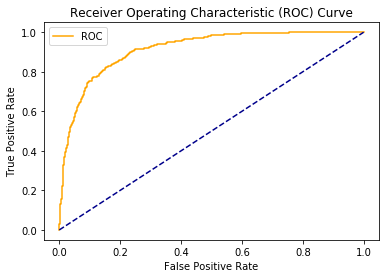

Confusion matrix: 
 [[1861  223]
 [  92  290]]
Classification Report 
               precision    recall  f1-score   support

       False       0.95      0.89      0.92      2084
        True       0.57      0.76      0.65       382

    accuracy                           0.87      2466
   macro avg       0.76      0.83      0.79      2466
weighted avg       0.89      0.87      0.88      2466



In [0]:
classify('LR', LogisticRegression(solver='liblinear', random_state=0), flag=False)

Train set
roc-auc: 0.9526024001756905
Test set
roc-auc: 0.9344595069891771


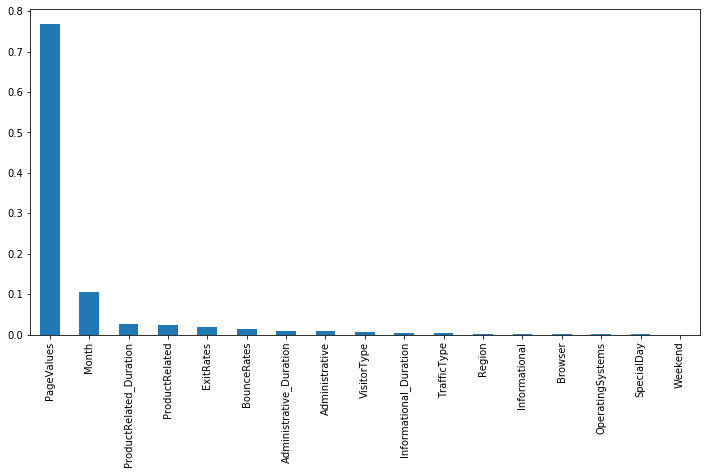

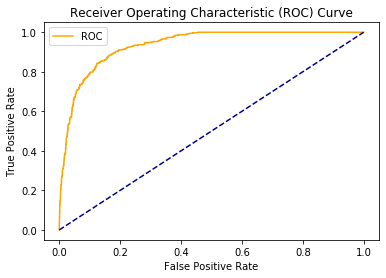

Confusion matrix: 
 [[1820  264]
 [  60  322]]
Classification Report 
               precision    recall  f1-score   support

       False       0.97      0.87      0.92      2084
        True       0.55      0.84      0.67       382

    accuracy                           0.87      2466
   macro avg       0.76      0.86      0.79      2466
weighted avg       0.90      0.87      0.88      2466



In [0]:
classify('gbm', GradientBoostingClassifier(random_state=0))

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packa

Train set
roc-auc: 0.9588814480729362
Test set
roc-auc: 0.9355975721277043


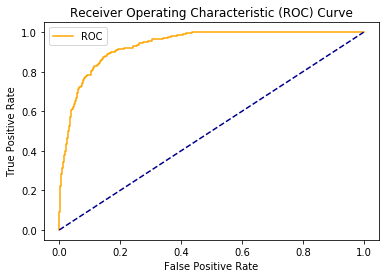

Confusion matrix: 
 [[1831  253]
 [  65  317]]
Classification Report 
               precision    recall  f1-score   support

       False       0.97      0.88      0.92      2084
        True       0.56      0.83      0.67       382

    accuracy                           0.87      2466
   macro avg       0.76      0.85      0.79      2466
weighted avg       0.90      0.87      0.88      2466



In [0]:
 clf = BayesSearchCV(
    GradientBoostingClassifier(),
    {
        'learning_rate' : Real(1e-3, 1e-1, prior= 'log-uniform'),
        'n_estimators' : Integer(100, 150),
        'max_features' : Integer(1,17)     
    },
    n_iter=64,
    random_state=0
)

classify('gbm', clf, flag=False)

Train set
roc-auc: 0.9507622121633472
Test set
roc-auc: 0.9356453055441107


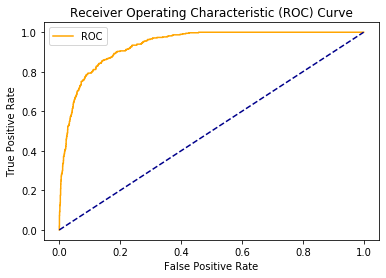

Confusion matrix: 
 [[1814  270]
 [  62  320]]
Classification Report 
               precision    recall  f1-score   support

       False       0.97      0.87      0.92      2084
        True       0.54      0.84      0.66       382

    accuracy                           0.87      2466
   macro avg       0.75      0.85      0.79      2466
weighted avg       0.90      0.87      0.88      2466



In [0]:
classify('xbg', XGB())